<a id="inicio-notebook"></a>
# Proyecto End to End de Machine Learning 
### Viviendas en venta en Madrid


## 0. Librerías
 

In [1]:
# importación agrupada de librerías necesarias en este notebook
import pandas as pd
import numpy as np


import sys
import os
from datetime import date

from scipy import stats
from scipy.stats import chi2_contingency
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

#warnings.filterwarnings('ignore')

# Añado el directorio padre (del que está este notebook) a sys.path
sys.path.append(os.path.abspath('../'))
from scripts.utils_agv import ini_inspec, crear_tabla_resumen, categoricas, numericas

### Configuración para visualizaciones

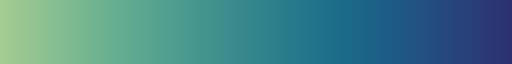

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.color_palette("crest", as_cmap=True)

<a id="baseline"></a> 
## 17. ¿Qué modelos? Baseline

(viene del notebook anterior, el conjunto de datos 'test' aquí NUNCA llegan los datos de test) He guardado los dataframe a probar en formato parquet.

Primero, importamos el parquet que queremos probar en todos nuestros modelos.

**Dataframe sin outliers, df5 con las variables o características transformadas con PCA, y limitado al 95% de la varianza explicada**

In [3]:
# introduzco aquí el Dataframe en cuestión 
file = 'train_sinOutliers_df5PCA.parquet'
file_path = f'../data/processed/{file}' 
df = pd.read_parquet(file_path, engine="pyarrow")

In [4]:
#comprobación
df.loc[[107526421], :]


,priceLog,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
ID,,,,,,,,,,,,,,,,,,,,
107526421,13.906265,2.103114,-1.698204,3.545112,-0.090094,-1.377033,-1.639007,-1.205345,2.728724,1.516274,2.535263,2.271264,3.221084,2.758554,-0.157792,-0.206483,-0.18905,-0.180025,0.335225,-0.59283


In [5]:
df.shape

(1337, 20)

Primeramente hago una separación de entrenamiento y validación, para evaluar mis modelos:

In [6]:
X = df.drop(['priceLog'], axis=1)  # Eliminamos la variable objetivo
y = df['priceLog']

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de validación: {X_val.shape}")

Tamaño del conjunto de entrenamiento: (1069, 19)
Tamaño del conjunto de validación: (268, 19)


In [8]:
# Modelo Dummy (Baseline)
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

# Predicción en la escala logarítmica
y_pred_dummy_log = dummy.predict(X_val)

# Transformar los valores a la escala original
y_val_original = np.exp(y_val)  # Revertir log(price)
y_pred_dummy_original = np.exp(y_pred_dummy_log)

# Evaluación con RMSE en la escala original
rmse_dummy = np.sqrt(mean_squared_error(y_val_original, y_pred_dummy_original))
print(f"RMSE (escala original): {rmse_dummy:,.2f} €")

# Evaluación con MAPE en la escala original
mape_dummy = mean_absolute_percentage_error(y_val_original, y_pred_dummy_original) * 100
print(f"MAPE (escala original): {mape_dummy:.2f} %")

RMSE (escala original): 597,080.46 €
MAPE (escala original): 69.13 %


### Baseline
Ahora que tenemos un modelo muy básico de referencia, realizo mi Baseline con varios modelos para regresión.


Modelo: Regresión Lineal
RMSE CV: 0.31
RMSE val (original): 351,609.88 €
MAPE val (original): 24.33 %

Modelo: Ridge
RMSE CV: 0.31
RMSE val (original): 351,566.76 €
MAPE val (original): 24.33 %

Modelo: Lasso
RMSE CV: 0.67
RMSE val (original): 573,215.61 €
MAPE val (original): 63.71 %

Modelo: Random Forest
RMSE CV: 0.29
RMSE val (original): 295,823.06 €
MAPE val (original): 21.67 %

Modelo: Gradient Boosting
RMSE CV: 0.29
RMSE val (original): 316,289.39 €
MAPE val (original): 23.24 %

Modelo: SVR
RMSE CV: 0.30
RMSE val (original): 290,238.22 €
MAPE val (original): 22.41 %

Modelo: Regresión Bayesiana
RMSE CV: 0.31
RMSE val (original): 351,085.90 €
MAPE val (original): 24.32 %

Modelo: KNN Regressor
RMSE CV: 0.37
RMSE val (original): 344,767.71 €
MAPE val (original): 29.30 %


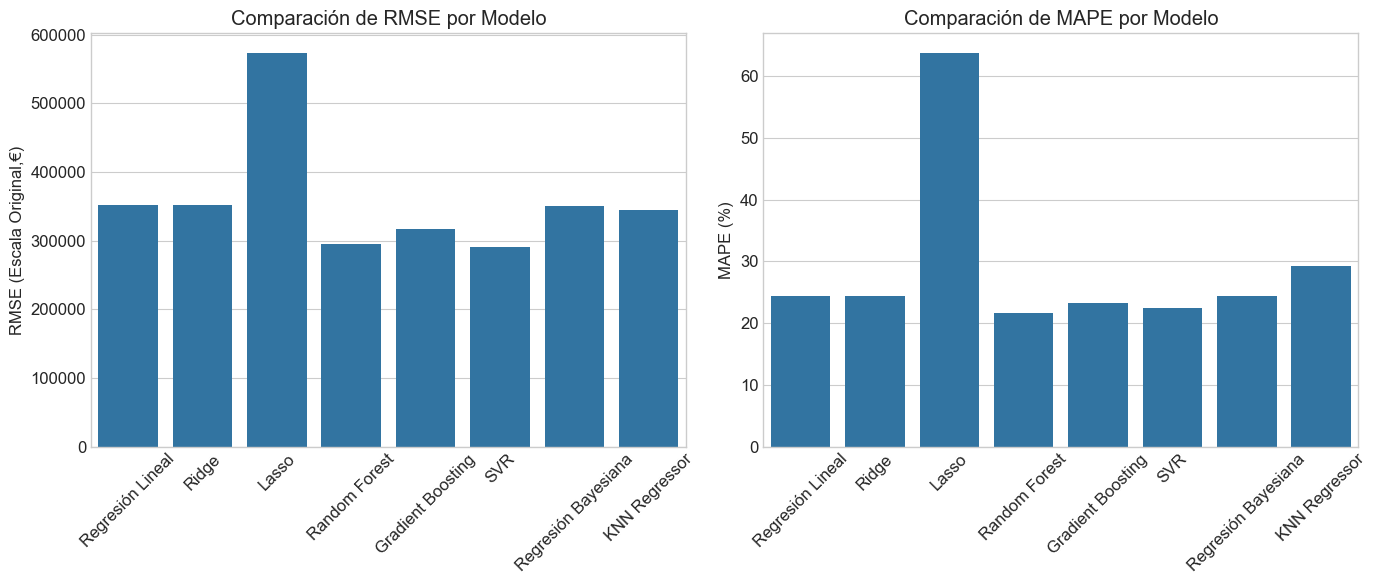

In [9]:
# BASELINE modelos de regresión
def evaluar_modelos(X_train, X_val, y_train, y_val, grafico_error=True):
    """
    Evalúa múltiples modelos de regresión y devuelve métricas de error (RMSE y MAPE) en la escala original.
    
    Parámetros:
        - X_train, X_val: Variables predictoras para entrenamiento y validación
        - y_train, y_val: Variables objetivo en la escala logarítmica
        - grafico_error (bool): Si es True, muestra los gráficos de comparación

    Retorna:
        - resultados (dict): Diccionario con las métricas de cada modelo
    """

    # Definir modelos
    modelos = {
        'Regresión Lineal': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'SVR': SVR(),
        'Regresión Bayesiana': BayesianRidge(),
        'KNN Regressor': KNeighborsRegressor(n_neighbors=5)  # Nuevo modelo KNN
    }

    resultados = {}

    for nombre, modelo in modelos.items():
        # Validación cruzada (CV) en la escala logarítmica
        mse_cv = -cross_val_score(modelo, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        rmse_cv = np.sqrt(mse_cv)

        # Entrenamiento del modelo
        modelo.fit(X_train, y_train)

        # Predicciones en la escala logarítmica
        y_pred_log = modelo.predict(X_val)

        # Transformar a la escala original
        y_val_original = np.exp(y_val)
        y_pred_original = np.exp(y_pred_log)

        # Evaluación en la escala original
        rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_original))
        mape = mean_absolute_percentage_error(y_val_original, y_pred_original) * 100

        # Guardar resultados
        resultados[nombre] = {
            'RMSE CV': rmse_cv.mean(),
            'RMSE Val': rmse,
            'MAPE Val': mape,
            'Modelo': modelo
        }

        # Imprimir métricas
        print(f"\nModelo: {nombre}")
        print(f"RMSE CV: {rmse_cv.mean():,.2f}")
        print(f"RMSE val (original): {rmse:,.2f} €")
        print(f"MAPE val (original): {mape:.2f} %")

    # Si grafico_error es True, mostramos las comparaciones gráficas
    if grafico_error:
        nombres_modelos = list(resultados.keys())
        rmse_valores = [resultados[m]['RMSE Val'] for m in nombres_modelos]
        mape_valores = [resultados[m]['MAPE Val'] for m in nombres_modelos]

        plt.figure(figsize=(14, 6))

        # Gráfico RMSE
        plt.subplot(1, 2, 1)
        sns.barplot(x=nombres_modelos, y=rmse_valores)
        plt.title('Comparación de RMSE por Modelo')
        plt.xticks(rotation=45)
        plt.ylabel('RMSE (Escala Original,€)')

        # Gráfico MAPE
        plt.subplot(1, 2, 2)
        sns.barplot(x=nombres_modelos, y=mape_valores)
        plt.title('Comparación de MAPE por Modelo')
        plt.xticks(rotation=45)
        plt.ylabel('MAPE (%)')

        plt.tight_layout()
        plt.show()

    return resultados

# Uso de la función
resultados_modelos = evaluar_modelos(X_train, X_val, y_train, y_val, grafico_error=True)


_Empleando PCA el modelo no mejora, todos los resultados empeoran_